# MadMiner : Laboritory for Testing - Room 1

This is a research lab to test the validate of the mined material.  

## 0. Reseach Library: 

In [5]:
#Set right path to MadMiner
import sys
import os
delphes_src_path = "/Users/felixkling/Documents/GitHub/delphesminer"
sys.path.append(delphes_src_path)
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

#Import MadMiner
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline

from madminer.goldmine import GoldMine
from madminer.refinery import combine_and_shuffle
from madminer.refinery import Refinery
from madminer.refinery import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.refinery import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.tools.plots import plot_2d_morphing_basis
from delphesprocessor.delphesprocessor import DelphesProcessor

#Set Path to MG5 directory
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Select Samples

The last important MadMiner class is the `Smithy`. From all the data we have in the HDF5 file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the Machine Learning algorithms.

The Refinery class defines four different high-level functions to generate train or test samples:

    extract_samples_train_plain(), which only saves observations x, for instance for histograms or ABC;
    extract_samples_train_local() for methods like SALLY and SALLINO;
    extract_samples_train_ratio() for techniques like CARL, ROLR, CASCAL, and RASCAL; and
    extract_samples_test() for the evaluation of any method.

For the arguments theta, theta0, or theta1, you can use the helper functions constant_benchmark_theta(), multiple_benchmark_thetas(), constant_morphing_theta(), multiple_morphing_thetas(), and random_morphing_thetas(), all defined in the smithy module.

In [2]:
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=True)

A, theta = refinery.extract_samples_test(
    theta=constant_morphing_theta(np.array([1.e-5,0.])),
    n_samples=1000,
    folder='./datasave/samples',
    filename='test'
)

15:32  
15:32  ------------------------------------------------------------
15:32  |                                                          |
15:32  |  MadMiner                                                |
15:32  |                                                          |
15:32  |  Version from July 24, 2018                              |
15:32  |                                                          |
15:32  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:32  |                                                          |
15:32  ------------------------------------------------------------
15:32  
15:32  
    
                                                      @ @ @ @   @ @ @ @                                
                                                     @. . . . @ . . . . @                              
                                                     @. . . . . . . . . @                              
                   @@@@@@@@@@@@@@@             

## 2. A first look: Corner Plot

Let's have a quick look at a corner plot. They look cool 

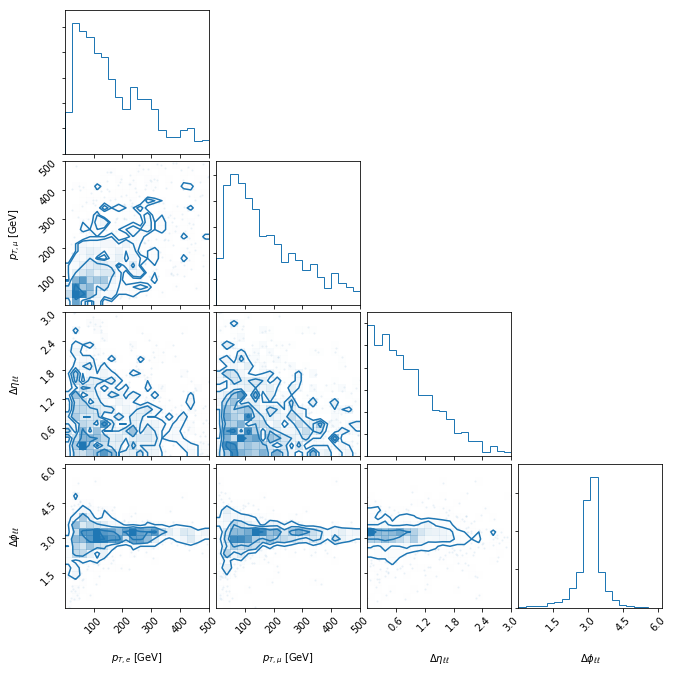

In [4]:
import corner

labels = [r'$p_{T,e}$ [GeV]', r'$p_{T,\mu}$ [GeV]', r'$\Delta \eta_{\ell\ell}$', r'$\Delta \phi_{\ell\ell}$']
ranges = [(0., 500.), (0., 500.), (0.,3.), (0.,6.2)]

_ = corner.corner(A, color='C0', labels=labels, range=ranges)

## 3. Quality Test A : Comapre Refinery to Raw Distribution for same Sample

Output of refinery.extract_samples_test(theta) has to have the same distribution as in the Delphes ROOT file, if theta is the same we used to generate the original MadGraph samples. 

In [ ]:
#Define Parameter Point
point = np.array([8.08,9.5]);

#Setup Refinery and load data
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=True)

x, theta = refinery.extract_samples_test(
    theta=constant_morphing_theta(point),
    n_samples=100000,
    folder='./datasave/samples',
    filename='test'
)
raw_x, raw_weights = refinery.extract_raw_data(theta=point)

# Number of Observables and Total Weight
n_observables = len(raw_x[0])
weight_total  = sum(raw_weights)

# Raw Data:
n_events_raw  = len(raw_x)
data_raw      = np.zeros( (n_observables,n_events_raw) )
weight_raw    = np.zeros( (n_events_raw) )
for i in range(0,n_observables):
    for j in range(0,n_events_raw):
        data_raw[i][j]   = raw_x[j][i]

for j in range(0,n_events_raw):
    weight_raw[j] = raw_weights[j]
        
# Refined Data
n_events_refine  = len(x)
data_refine      = np.zeros( (n_observables,n_events_refine) )
weight_refine    = np.zeros( (n_events_refine) )
for i in range(0,n_observables):
    for j in range(0,n_events_refine):
        data_refine[i][j] = x[j][i]

for j in range(0,n_events_refine):
    weight_refine[j] = weight_total/n_events_refine   

In [ ]:
# Do some plotting
xlabels = [r'$p_{T,e}$ [GeV]', r'$p_{T,\mu}$ [GeV]', r'$\Delta \eta_{\ell\ell}$', r'$\Delta \phi_{\ell\ell}$']
ylabels = [r'$d\sigma/dp_{T,e}$ [pb/bin]', r'$d\sigma/p_{T,\mu}$ [pb/bin]', r'$d\sigma/\Delta \eta_{\ell\ell} [pb/bin]$', r'$d\sigma/\Delta \phi_{\ell\ell} [pb/bin]$']
ranges = [(0., 500.), (0., 500.), (0.,3.), (0.,6.2)]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.set_size_inches(11,8)

ax1.set_xlabel(xlabels[0])
ax1.set_ylabel(ylabels[0])
ax1.hist(data_refine[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_refine)
ax1.hist(data_raw[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'))

ax2.set_xlabel(xlabels[1])
ax2.set_ylabel(ylabels[1])
ax2.hist(data_refine[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_refine,label="Refinery")
ax2.hist(data_raw[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'),label="Raw")
ax2.legend(bbox_to_anchor=(0.6, 0.95), loc=2, borderaxespad=0.)

ax3.set_xlabel(xlabels[2])
ax3.set_ylabel(ylabels[2])
ax3.hist(data_refine[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_refine)
ax3.hist(data_raw[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'))

ax4.set_xlabel(xlabels[3])
ax4.set_ylabel(ylabels[3])
ax4.hist(data_refine[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_refine)
ax4.hist(data_raw[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'))

plt.show()

## 4. Quality Test B : Compare Refinery and Raw Distributiosn for Different Sample

Generate two samples A and B, one based on thetaA and one on thetaB. Analyse the one from thetaA with MadMiner and put out refinery.extract_samples_test(theta=thetaB). Compare the distributions to those from the sample originally based on thetaB. This also checks the morphing in a non-trivial way.

In [5]:
#Define Parameter Point
point = np.array([0.,0.])

# Raw data
refineryB = Refinery('datasave/madminer_example_shuffled_runB.h5', debug=False)

data_raw, weight_raw = refineryB.extract_raw_data()
weight_raw = weight_raw[:,5]
data_raw = data_raw.T

# Refined data
refineryA = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=False)

data_refine, _ = refineryA.extract_samples_test(
    theta=constant_morphing_theta(point),
    n_samples=300000,
    folder='./datasave/samples',
    filename='test'
)

data_refine = data_refine.T
weight_refine = sum(weight_raw) / len(data_refine[0]) * np.ones_like(data_refine[0])


15:35  
15:35  ------------------------------------------------------------
15:35  |                                                          |
15:35  |  MadMiner                                                |
15:35  |                                                          |
15:35  |  Version from July 24, 2018                              |
15:35  |                                                          |
15:35  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:35  |                                                          |
15:35  ------------------------------------------------------------
15:35  
15:35  
    
                                                      @ @ @ @   @ @ @ @                                
                                                     @. . . . @ . . . . @                              
                                                     @. . . . . . . . . @                              
                   @@@@@@@@@@@@@@@             

15:35  Loading data from datasave/madminer_example_shuffled_runA.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:35  Found 6 benchmarks:
15:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:35     bsm1: CWL2 = 4.00, CPWL2 = 0.00e+00
15:35     bsm2: CWL2 = -7.64e+00, CPWL2 = -7.01e+00
15:35     bsm3: CWL2 = 3.29, CPWL2 = -9.86e+00
15:35     bsm4: CWL2 = -8.68e+00, CPWL2 = 6.87
15:35     bsm5: CWL2 = 8.08, CPWL2 = 9.50
15:35  Found 4 observables: pt_e1, pt_mu1, delta_eta_ll, delta_phi_ll
15:35  Found 562576 events
15:35  Found morphing setup with 6 components
15:35  Extracting evaluation sample. Sampling according to (u'theta', array([0., 0.]))
15:35  Starting sample extraction
15:35    sampling thetas:  [(u'morphing', array([0., 0.]))]
15:35  After balancing:
15:35    sampling thetas:  [(u'morphing', array([0., 0.]))]
15:35    auxiliary th

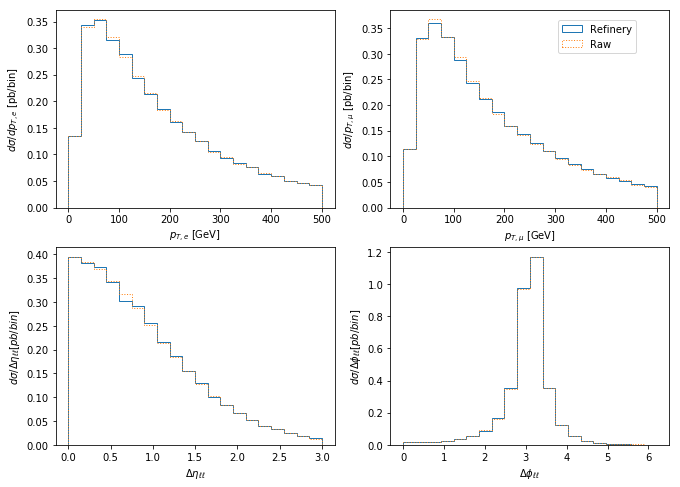

In [6]:
# Do some plotting
xlabels = [r'$p_{T,e}$ [GeV]', r'$p_{T,\mu}$ [GeV]', r'$\Delta \eta_{\ell\ell}$', r'$\Delta \phi_{\ell\ell}$']
ylabels = [r'$d\sigma/dp_{T,e}$ [pb/bin]', r'$d\sigma/p_{T,\mu}$ [pb/bin]', r'$d\sigma/\Delta \eta_{\ell\ell} [pb/bin]$', r'$d\sigma/\Delta \phi_{\ell\ell} [pb/bin]$']
ranges = [(0., 500.), (0., 500.), (0.,3.), (0.,6.2)]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.set_size_inches(11,8)

ax1.set_xlabel(xlabels[0])
ax1.set_ylabel(ylabels[0])
ax1.hist(data_refine[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_refine)
ax1.hist(data_raw[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'))

ax2.set_xlabel(xlabels[1])
ax2.set_ylabel(ylabels[1])
ax2.hist(data_refine[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_refine,label="Refinery")
ax2.hist(data_raw[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'),label="Raw")
ax2.legend(bbox_to_anchor=(0.6, 0.95), loc=2, borderaxespad=0.)

ax3.set_xlabel(xlabels[2])
ax3.set_ylabel(ylabels[2])
ax3.hist(data_refine[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_refine)
ax3.hist(data_raw[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'))

ax4.set_xlabel(xlabels[3])
ax4.set_ylabel(ylabels[3])
ax4.hist(data_refine[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_refine)
ax4.hist(data_raw[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_raw, linestyle=('dotted'))

plt.show()

## 5. Quality Test C : Compare Joint Ratios and Joint Scores? 

Check if the joint score components can be reproduced by the joint ratio:  `t(x,z|th0)_i = log[r(x,z|th1,th0)]/(th1_i-th0_i)` for two close th0 and th1

In [ ]:
#Setup Refinery and load data
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=False)

In [ ]:
from math import log

#Calculate t and r 
point0 = np.array([1.1,0])
point1 = np.array([0,0])
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=constant_morphing_theta(point0),
    theta1=constant_morphing_theta(point1),
    n_samples=400,
    folder='./datasave/samples',
    filename='train_rascal'
)

#Calculate Score:
n_events = len(x)
n_thetas = len(theta0[0])

score_refinery = np.zeros( (n_thetas ,n_events) )
score_check    = np.zeros( (n_thetas ,n_events) )
for ith in range(0,n_thetas):
    for iev in range(0,n_events):
#        if y[iev]!=0: 
#            continue
        score_refinery[ith][iev] = t_xz[iev][ith]
#        score_check[ith][iev]    = (r_xz[iev][0]-1.)/(theta0[iev][ith]-theta1[iev][ith])   
        score_check[ith][iev]    = log(r_xz[iev][0])/(theta0[iev][ith]-theta1[iev][ith])   

fig = plt.figure(figsize=(5,5))
plt.scatter(score_refinery[0], score_check[0],  c="g", alpha=0.5)
plt.scatter(score_refinery[1], score_check[1],  c="b", alpha=0.5)
plt.xlabel("t[z,z|th0]_i")
plt.ylabel("log(r[x,z|th1,th0])/(th1-th0)_i")
plt.title('th0=('+str(point0[0])+','+str(point0[1])+'),   th1=('+str(point1[0])+','+str(point1[1])+')')
plt.xlim(-0.0005, 0.0005)
plt.ylim(-0.0005, 0.0005)
plt.show()

### 5.1. Bug Report: Look at distribution of theta0 from refinery.extract_samples_train_ratio()

Is that supposed to be like this? 

In [2]:
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=False)

15:37  
15:37  ------------------------------------------------------------
15:37  |                                                          |
15:37  |  MadMiner                                                |
15:37  |                                                          |
15:37  |  Version from July 24, 2018                              |
15:37  |                                                          |
15:37  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:37  |                                                          |
15:37  ------------------------------------------------------------
15:37  
15:37  Loading data from datasave/madminer_example_shuffled_runA.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:37     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:37  Found 6 benchmarks:
15:37     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:37     bsm1: CWL2 = 4.00, CPWL2 

15:38  Extracting training sample for ratio-based methods. Numerator hypothesis: (u'random', (None, [(u'gaussian', 0.0, 0.5), (u'flat', -0.5, 0.5)])), denominator hypothesis: (u'benchmark', u'sm')


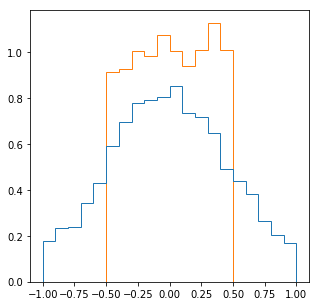

In [4]:
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=random_morphing_thetas(None, [('gaussian', 0., 0.5), ('flat', -0.5, 0.5)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=5000,
    folder='./datasave/samples',
    filename='train_rascal'
)

fig = plt.figure(figsize=(5,5))
plt.hist(theta0, range=(-1,1), bins=20, histtype='step', normed=True)
plt.show()

## 6. Test D: Reweight distributions by r_xz

Take the output from refinery.extract_samples_train_ratio(theta0, theta1), weight each y=1 sample with r_xz, and compare the distribution of this weighted y=1 sample to the (unweighted) distribution of the y=0 sample. They should be the same.

In [21]:
#Setup Refinery and load data
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=False)

#Calculate t and r 
point0 = np.array([0.,0])
point1 = np.array([20,20.])
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=constant_morphing_theta(point0),
    theta1=constant_morphing_theta(point1),
    n_samples=10000,
    folder='./datasave/samples',
    filename='train_rascal'
)

_ , raw_weights_0 = refinery.extract_raw_data(theta=point0)
_ , raw_weights_1 = refinery.extract_raw_data(theta=point1)

#Split y=0,1
x_y0=x[y==0]
x_y1=x[y==1]
r_xz_y0=r_xz[y==0]
r_xz_y1=r_xz[y==1]

# Data + Weights
data_y0   = x_y0.T
weight_y0 = sum(raw_weights_0) / len(data_y0[0]) * np.ones_like(data_y0[0])    
        
data_y1   = x_y1.T
weight_y1 = sum(raw_weights_1) / len(data_y1[0]) * np.ones_like(data_y1[0])    
reweight_y1 = sum(raw_weights_1) / len(data_y1[0]) * r_xz_y1    

15:52  
15:52  ------------------------------------------------------------
15:52  |                                                          |
15:52  |  MadMiner                                                |
15:52  |                                                          |
15:52  |  Version from July 24, 2018                              |
15:52  |                                                          |
15:52  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:52  |                                                          |
15:52  ------------------------------------------------------------
15:52  
15:52  Loading data from datasave/madminer_example_shuffled_runA.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:52  Found 6 benchmarks:
15:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:52     bsm1: CWL2 = 4.00, CPWL2 

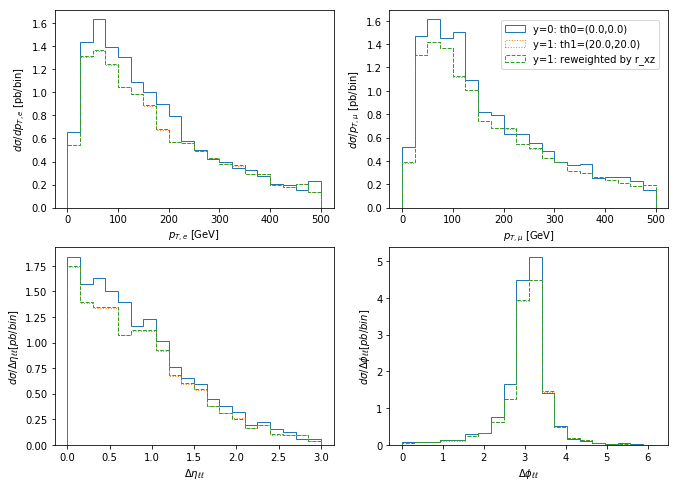

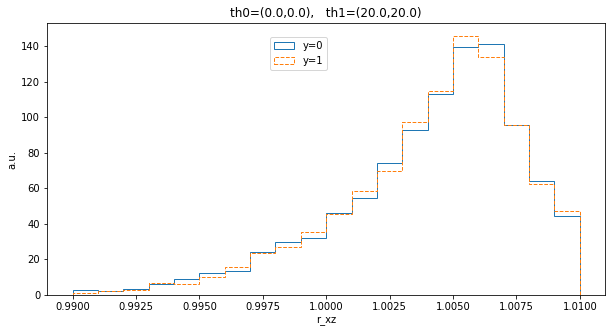

In [22]:
# Do some plotting
xlabels = [r'$p_{T,e}$ [GeV]', r'$p_{T,\mu}$ [GeV]', r'$\Delta \eta_{\ell\ell}$', r'$\Delta \phi_{\ell\ell}$']
ylabels = [r'$d\sigma/dp_{T,e}$ [pb/bin]', r'$d\sigma/p_{T,\mu}$ [pb/bin]', r'$d\sigma/\Delta \eta_{\ell\ell} [pb/bin]$', r'$d\sigma/\Delta \phi_{\ell\ell} [pb/bin]$']
ranges = [(0., 500.), (0., 500.), (0.,3.), (0.,6.2)]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.set_size_inches(11,8)

ax1.set_xlabel(xlabels[0])
ax1.set_ylabel(ylabels[0])
ax1.hist(data_y0[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_y0)
ax1.hist(data_y1[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_y1, linestyle=('dotted'))
ax1.hist(data_y1[0], range=ranges[0], bins=20, histtype='step', 
         weights=reweight_y1, linestyle=('dashed'))

ax2.set_xlabel(xlabels[1])
ax2.set_ylabel(ylabels[1])
ax2.hist(data_y0[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_y0,label='y=0: th0=('+str(point0[0])+','+str(point0[1])+')')
ax2.hist(data_y1[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_y1, linestyle=('dotted'),label='y=1: th1=('+str(point1[0])+','+str(point1[1])+')')
ax2.hist(data_y1[1], range=ranges[1], bins=20, histtype='step', 
         weights=reweight_y1, linestyle=('dashed'),label='y=1: reweighted by r_xz')
ax2.legend(bbox_to_anchor=(0.4, 0.95), loc=2, borderaxespad=0.)


ax3.set_xlabel(xlabels[2])
ax3.set_ylabel(ylabels[2])
ax3.hist(data_y0[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_y0)
ax3.hist(data_y1[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_y1, linestyle=('dotted'))
ax3.hist(data_y1[2], range=ranges[2], bins=20, histtype='step', 
         weights=reweight_y1, linestyle=('dashed'))

ax4.set_xlabel(xlabels[3])
ax4.set_ylabel(ylabels[3])
ax4.hist(data_y0[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_y0)
ax4.hist(data_y1[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_y1, linestyle=('dotted'))
ax4.hist(data_y1[3], range=ranges[3], bins=20, histtype='step', 
         weights=reweight_y1, linestyle=('dashed'))

plt.show()

### 6a. Bug2: check r_xz distribution

In [29]:
#Setup Refinery and load data
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=False)


#Calculate t and r 
point0 = np.array([0.,0])
point1 = np.array([20,20.])
x, theta0, theta1, y, r_xz, t_xz = refinery.extract_samples_train_ratio(
    theta0=constant_benchmark_theta('bsm1'),
    theta1=constant_benchmark_theta('sm'),
#    theta0=constant_morphing_theta(point0),
#    theta1=constant_morphing_theta(point1),
    n_samples=10000,
    folder='./datasave/samples',
    filename='train_rascal'
)

#Split y=0,1
r_xz_y0=r_xz[y==0]
r_xz_y1=r_xz[y==1]

16:01  
16:01  ------------------------------------------------------------
16:01  |                                                          |
16:01  |  MadMiner                                                |
16:01  |                                                          |
16:01  |  Version from July 24, 2018                              |
16:01  |                                                          |
16:01  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:01  |                                                          |
16:01  ------------------------------------------------------------
16:01  
16:01  Loading data from datasave/madminer_example_shuffled_runA.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     bsm1: CWL2 = 4.00, CPWL2 

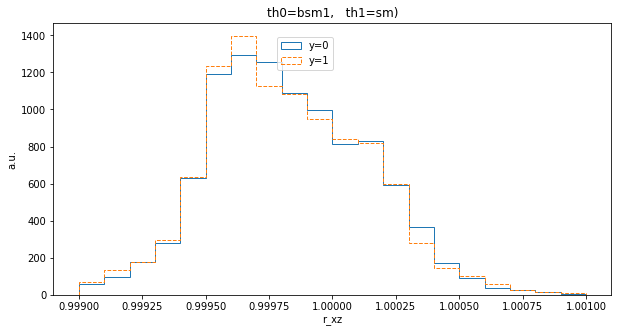

In [32]:
fig = plt.figure(figsize=(10,5))
plt.xlabel('r_xz')
plt.ylabel('a.u.')
plt.hist(r_xz_y0, range=(0.999,1.001), bins=20, histtype='step',normed=True,label='y=0')
plt.hist(r_xz_y1, range=(0.999,1.001), bins=20, histtype='step',normed=True,linestyle=('dashed'),label='y=1')
plt.legend(bbox_to_anchor=(0.4, 0.95), loc=2, borderaxespad=0.)
plt.title('th0=bsm1,   th1=sm)')
#plt.title('th0=('+str(point0[0])+','+str(point0[1])+'),   th1=('+str(point1[0])+','+str(point1[1])+')')
plt.show()

### 6b. Just plot distributions for different thetas

In [23]:
#Setup Refinery and load data
refinery = Refinery('datasave/madminer_example_shuffled_runA.h5', debug=False)

#Calculate t and r 
point1 = np.array([0.,0])
point2 = np.array([50.,50.])

x1, theta1 = refinery.extract_samples_test(
    theta=constant_morphing_theta(point1),
    n_samples=100000,
    folder='./datasave/samples',
    filename='test'
)

x2, theta2 = refinery.extract_samples_test(
    theta=constant_morphing_theta(point2),
    n_samples=100000,
    folder='./datasave/samples',
    filename='test'
)
_ , raw_weights_2 = refinery.extract_raw_data(theta=point2)
_ , raw_weights_1 = refinery.extract_raw_data(theta=point1)

# Data + Weights
data_x1   = x1.T
weight_x1 = sum(raw_weights_1) / len(data_x1[0]) * np.ones_like(data_x1[0])   

data_x2   = x2.T
weight_x2 = sum(raw_weights_2) / len(data_x2[0]) * np.ones_like(data_x2[0])   

15:55  
15:55  ------------------------------------------------------------
15:55  |                                                          |
15:55  |  MadMiner                                                |
15:55  |                                                          |
15:55  |  Version from July 24, 2018                              |
15:55  |                                                          |
15:55  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:55  |                                                          |
15:55  ------------------------------------------------------------
15:55  
15:55  Loading data from datasave/madminer_example_shuffled_runA.h5
15:55  Found 2 parameters:
15:55     CWL2 (LHA: dim6 2, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:55     CPWL2 (LHA: dim6 5, maximal power in squared ME: 2, range: (-10.0, 10.0))
15:55  Found 6 benchmarks:
15:55     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:55     bsm1: CWL2 = 4.00, CPWL2 

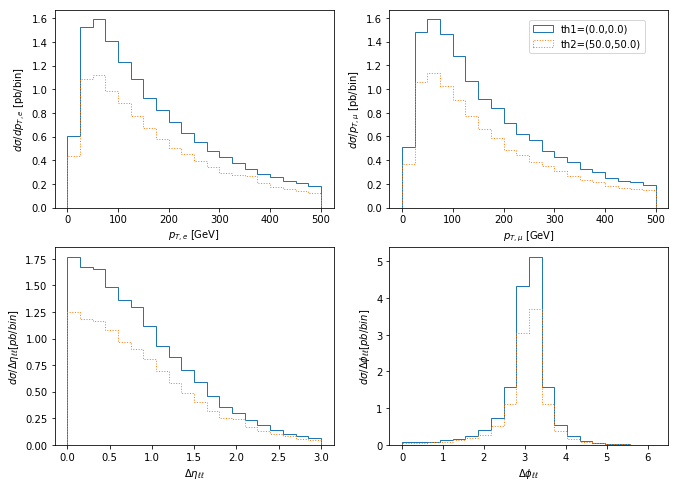

In [24]:
# Do some plotting
xlabels = [r'$p_{T,e}$ [GeV]', r'$p_{T,\mu}$ [GeV]', r'$\Delta \eta_{\ell\ell}$', r'$\Delta \phi_{\ell\ell}$']
ylabels = [r'$d\sigma/dp_{T,e}$ [pb/bin]', r'$d\sigma/p_{T,\mu}$ [pb/bin]', r'$d\sigma/\Delta \eta_{\ell\ell} [pb/bin]$', r'$d\sigma/\Delta \phi_{\ell\ell} [pb/bin]$']
ranges = [(0., 500.), (0., 500.), (0.,3.), (0.,6.2)]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.set_size_inches(11,8)

ax1.set_xlabel(xlabels[0])
ax1.set_ylabel(ylabels[0])
ax1.hist(data_x1[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_x1)
ax1.hist(data_x2[0], range=ranges[0], bins=20, histtype='step', 
         weights=weight_x2, linestyle=('dotted'))

ax2.set_xlabel(xlabels[1])
ax2.set_ylabel(ylabels[1])
ax2.hist(data_x1[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_x1,label='th1=('+str(point1[0])+','+str(point1[1])+')')
ax2.hist(data_x2[1], range=ranges[1], bins=20, histtype='step', 
         weights=weight_x2, linestyle=('dotted'),label='th2=('+str(point2[0])+','+str(point2[1])+')')
ax2.legend(bbox_to_anchor=(0.5, 0.95), loc=2, borderaxespad=0.)

ax3.set_xlabel(xlabels[2])
ax3.set_ylabel(ylabels[2])
ax3.hist(data_x1[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_x1)
ax3.hist(data_x2[2], range=ranges[2], bins=20, histtype='step', 
         weights=weight_x2, linestyle=('dotted'))

ax4.set_xlabel(xlabels[3])
ax4.set_ylabel(ylabels[3])
ax4.hist(data_x1[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_x1)
ax4.hist(data_x2[3], range=ranges[3], bins=20, histtype='step', 
         weights=weight_x2, linestyle=('dotted'))

plt.show()